# Timeseries

Pandas started out in the financial world, so naturally it has strong timeseries support.

The first half of this post will look at pandas' capabilities for manipulating time series data.
The second half will discuss modelling time series data with statsmodels.

In [5]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

Let's grab some stock data for Goldman Sachs using the [`pandas-datareader`](http://pandas-datareader.readthedocs.io/en/latest/) package, which spun off of pandas:

In [2]:
gs = web.DataReader("GS", data_source='yahoo', start='2006-01-01',
                    end='2010-01-01')
gs.head().round(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.70,129.44,124.23,128.87,112.34,6188700
2006-01-04,127.35,128.91,126.38,127.09,110.79,4861600
2006-01-05,126.00,127.32,125.61,127.04,110.74,3717400
2006-01-06,127.29,129.25,127.29,128.84,112.31,4319600
2006-01-09,128.50,130.62,128.00,130.39,113.66,4723500


There isn't a special data-container just for time series in pandas, they're just `Series` or `DataFrame`s with a `DatetimeIndex`.

## Special Slicing

Looking at the elements of `gs.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

Looking at the elements of `gs.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

In [3]:
gs.index[0]

Timestamp('2006-01-03 00:00:00')

A `Timestamp` is mostly compatible with the `datetime.datetime` class, but much amenable to storage in arrays.

Working with `Timestamp`s can be awkward, so Series and DataFrames with `DatetimeIndexes` have some special slicing rules.
The first special case is *partial-string indexing*. Say we wanted to select all the days in 2006. Even with `Timestamp`'s convenient constructors, it's a pai

In [4]:
gs.loc[pd.Timestamp('2006-01-01'):pd.Timestamp('2006-12-31')].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,112.337547,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,110.785889,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,110.742340,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,112.311401,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,113.662605,4723500


Thanks to partial-string indexing, it's as simple as

In [5]:
gs.loc['2006'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,112.337547,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,110.785889,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,110.742340,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,112.311401,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,113.662605,4723500


Since label slicing is inclusive, this slice selects any observation where the year is 2006.

The second "convenience" is `__getitem__` (square-bracket) fall-back indexing. I'm only going to mention it here, with the caveat that you should never use it.
DataFrame `__getitem__` typically looks in the column: `gs['2006']` would search `gs.columns` for `'2006'`, not find it, and raise a `KeyError`. But DataFrames with a `DatetimeIndex` catch that `KeyError` and try to slice the index.
If it succeeds in slicing the index, the result like `gs.loc['2006']` is returned.
If it fails, the `KeyError` is re-raised.
This is confusing because in pretty much every other case `DataFrame.__getitem__` works on columns, and it's fragile because if you happened to have a column `'2006'` you *would* get just that column, and no fall-back indexing would occur. Just use `gs.loc['2006']` when slicing DataFrame indexes.


## Special Methods

### Resampling

Resampling is similar to a `groupby`: you split the time series into groups (5-day buckets below), apply a function to each group (`mean`), and combine the result (one row per group).

In [6]:
gs.resample("5d").mean().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.834999,128.730002,125.877501,127.959997,111.544294,4.771825e+06
2006-01-08,130.349998,132.645000,130.205002,131.660000,114.769649,4.664300e+06
2006-01-13,131.510002,133.395005,131.244995,132.924995,115.872357,3.258250e+06
2006-01-18,132.210002,133.853333,131.656667,132.543335,115.611125,4.997767e+06
2006-01-23,133.771997,136.083997,133.310001,135.153998,118.035918,3.968500e+06


In [7]:
gs.resample("W").agg(['mean', 'sum']).head()

Open                    High                     Low  \
                  mean         sum        mean         sum        mean   
Date                                                                     
2006-01-08  126.834999  507.339996  128.730002  514.920006  125.877501   
2006-01-15  130.684000  653.419998  132.848001  664.240006  130.544000   
2006-01-22  131.907501  527.630005  133.672501  534.690003  131.389999   
2006-01-29  133.771997  668.859986  136.083997  680.419983  133.310001   
2006-02-05  140.900000  704.500000  142.467999  712.339996  139.937998   

                             Close               Adj Close              \
                   sum        mean         sum        mean         sum   
Date                                                                     
2006-01-08  503.510002  127.959997  511.839988  111.544294  446.177177   
2006-01-15  652.720001  131.979999  659.899994  115.048592  575.242958   
2006-01-22  525.559998  132.555000  530.220000  115.603432  462.413728   
2006-01-29  666.550003  135.153998  675.769989  118.035918  590.179588   
2006-02-05  699.689988  141.618002  708.090011  123.681204  618.406020   

               Volume            
                 mean       sum  
Date                             
2006-01-08  4771825.0  19087300  
2006-01-15  4310420.0  21552100  
2006-01-22  4653725.0  18614900  
2006-01-29  3968500.0  19842500  
2006-02-05  3920120.0  19600600

You can up-sample to convert to a higher frequency.
The new points are filled with NaNs.

In [8]:
gs.resample("6H").mean().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03 00:00:00,126.699997,129.440002,124.230003,128.869995,112.337547,6188700.0
2006-01-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04 00:00:00,127.349998,128.910004,126.379997,127.089996,110.785889,4861600.0


### Rolling / Expanding / EW

These methods aren't unique to `DatetimeIndex`es, but they often make sense with time series, so I'll show them here.

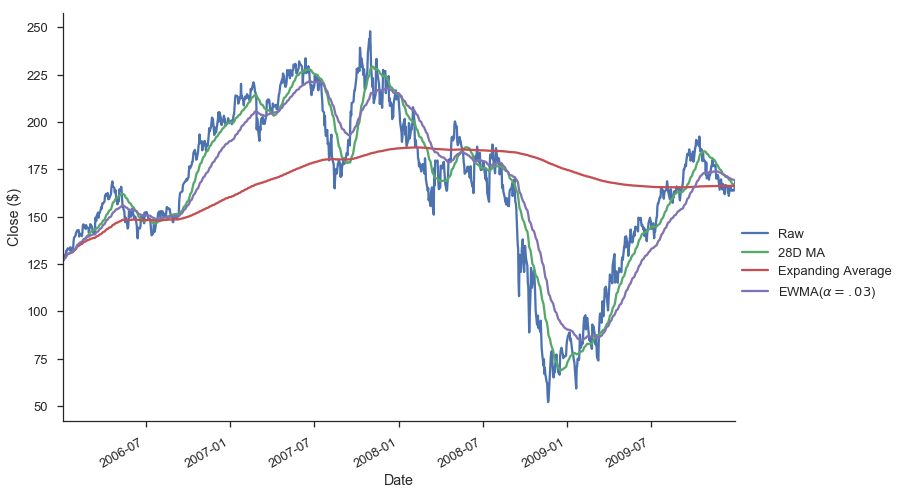

In [9]:
gs.Close.plot(label='Raw')
gs.Close.rolling(28).mean().plot(label='28D MA')
gs.Close.expanding().mean().plot(label='Expanding Average')
gs.Close.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

Each of `.rolling`, `.expanding`, and `.ewm` return a deferred object, similar to a GroupBy.

In [10]:
roll = gs.Close.rolling(30, center=True)
roll

Rolling [window=30,center=True,axis=0]

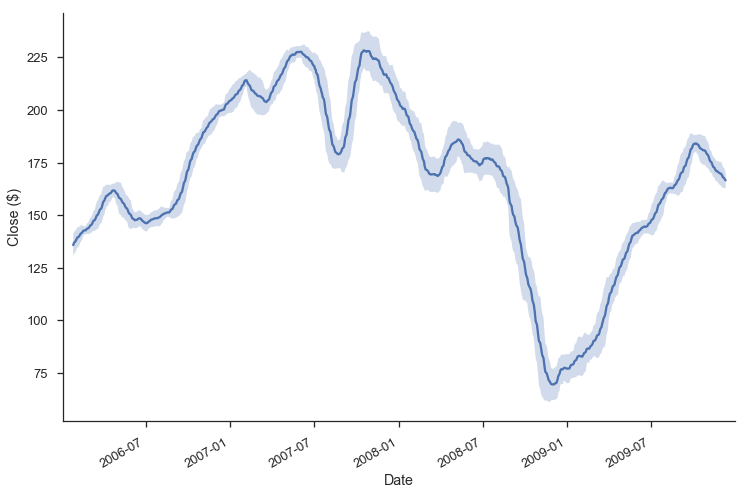

In [11]:
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot()
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

## Grab Bag

### Offsets

These are similar to `dateutil.relativedelta`, but works with arrays.

In [12]:
gs.index + pd.DateOffset(months=3, days=-2)

DatetimeIndex(['2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-07', '2006-04-08', '2006-04-09', '2006-04-10',
               '2006-04-11', '2006-04-15',
               ...
               '2010-03-15', '2010-03-16', '2010-03-19', '2010-03-20',
               '2010-03-21', '2010-03-22', '2010-03-26', '2010-03-27',
               '2010-03-28', '2010-03-29'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

### Holiday Calendars

There are a whole bunch of special calendars, useful for traders probably.

In [13]:
from pandas.tseries.holiday import USColumbusDay

In [14]:
USColumbusDay.dates('2015-01-01', '2020-01-01')

DatetimeIndex(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
               '2019-10-14'],
              dtype='datetime64[ns]', freq='WOM-2MON')

### Timezones

Pandas works with `pytz` for nice timezone-aware datetimes.
The typical workflow is

1. localize timezone-naive timestamps to some timezone
2. convert to desired timezone

If you already have timezone-aware Timestamps, there's no need for step one. 

In [15]:
# tz naiive -> tz aware..... to desired UTC
gs.tz_localize('US/Eastern').tz_convert('UTC').head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03 05:00:00+00:00,126.699997,129.440002,124.230003,128.869995,112.337547,6188700
2006-01-04 05:00:00+00:00,127.349998,128.910004,126.379997,127.089996,110.785889,4861600
2006-01-05 05:00:00+00:00,126.000000,127.320000,125.610001,127.040001,110.742340,3717400
2006-01-06 05:00:00+00:00,127.290001,129.250000,127.290001,128.839996,112.311401,4319600
2006-01-09 05:00:00+00:00,128.500000,130.619995,128.000000,130.389999,113.662605,4723500


## Modeling Time Series

The rest of this post will focus on time series in the econometric sense.
My indented reader for this section isn't all that clear, so I apologize upfront for any sudden shifts in complexity.
I'm roughly targeting material that could be presented in a first or second semester applied statisctics course.
What follows certainly isn't a replacement for that.
Any formality will be restricted to footnotes for the curious.
I've put a whole bunch of resources at the end for people earger to learn more.

We'll focus on modelling Average Monthly Flights. Let's download the data.
If you've been following along in the series, you've seen most of this code before, so feel free to skip.

In [21]:
import os
import io
import glob
import zipfile
from utils import download_timeseries

import statsmodels.api as sm


def download_many(start, end):
    months = pd.period_range(start, end=end, freq='M')
    # We could easily parallelize this loop.
    for i, month in enumerate(months):
        download_timeseries(month)


def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,1149.0 -> 2014-01-01T11:49:00
    '''
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


def read_one(fp):
    df = (pd.read_csv(fp, encoding='latin1')
            .rename(columns=str.lower)
            .drop('unnamed: 6', axis=1)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time',
                                     'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date'])))
    return df

In [22]:
store = 'data/ts.hdf5'

if not os.path.exists(store):
    download_many('2000-01-01', '2016-01-01')

    zips = glob.glob(os.path.join('data', 'timeseries', '*.zip'))
    dfs = [read_one(fp) for fp in csvs]
    df = pd.concat(dfs, ignore_index=True)

    df['origin'] = df['origin'].astype('category')
    df.to_hdf(store, 'ts', format='table')
else:
    df = pd.read_hdf(store, 'ts')

In [23]:
with pd.option_context('display.max_rows', 100):
    print(df.dtypes)

fl_date         datetime64[ns]
origin                category
crs_dep_time    datetime64[ns]
dep_time        datetime64[ns]
crs_arr_time    datetime64[ns]
arr_time        datetime64[ns]
dtype: object


We can calculate the historical values with a resample.

In [24]:
daily = df.fl_date.value_counts().sort_index()
y = daily.resample('MS').mean()
y.head()

2000-01-01    15176.677419
2000-02-01    15327.551724
2000-03-01    15578.838710
2000-04-01    15442.100000
2000-05-01    15448.677419
Freq: MS, Name: fl_date, dtype: float64

Note that I use the `"MS"` frequency code there.
Pandas defaults to end of month (or end of year).
Append an `'S'` to get the start.

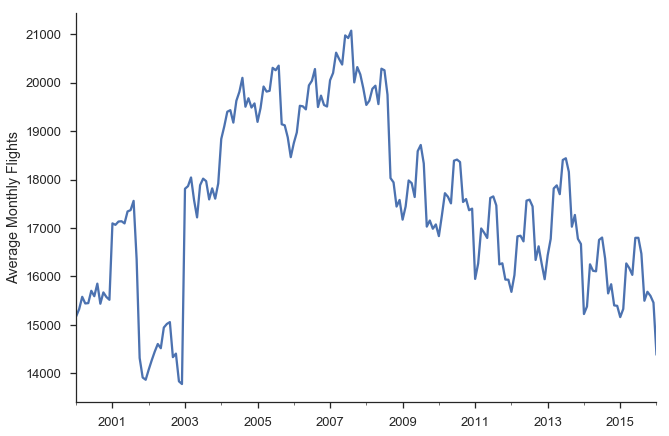

In [25]:
ax = y.plot()
ax.set(ylabel='Average Monthly Flights')
sns.despine()

In [26]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

One note of warning: I'm using the development version of statsmodels (commit `de15ec8` to be precise).
Not all of the items I've shown here are available in the currently-released version.

Think back to a typical regression problem, ignoring anything to do with time series for now.
The usual task is to predict some value $y$ using some a linear combination of features in $X$.

$$y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$

When working with time series, some of the most important (and sometimes *only*) features are the previous, or *lagged*, values of $y$.

Let's start by trying just that "manually": running a regression of `y` on lagged values of itself.
We'll see that this regression suffers from a few problems: multicollinearity, autocorrelation, non-stationarity, and seasonality.
I'll explain what each of those are in turn and why they're problems.
Afterwards, we'll use a second model, seasonal ARIMA, which handles those problems for us.

First, let's create a dataframe with our lagged values of `y` using the `.shift` method, which shifts the index `i` periods, so it lines up with that observation.

In [27]:
X = (pd.concat([y.shift(i) for i in range(6)], axis=1,
               keys=['y'] + ['L%s' % i for i in range(1, 6)])
       .dropna())
X.head()

,y,L1,L2,L3,L4,L5
2000-06-01,15703.333333,15448.677419,15442.100000,15578.838710,15327.551724,15176.677419
2000-07-01,15591.677419,15703.333333,15448.677419,15442.100000,15578.838710,15327.551724
2000-08-01,15850.516129,15591.677419,15703.333333,15448.677419,15442.100000,15578.838710
2000-09-01,15436.566667,15850.516129,15591.677419,15703.333333,15448.677419,15442.100000
2000-10-01,15669.709677,15436.566667,15850.516129,15591.677419,15703.333333,15448.677419


We can fit the lagged model using statsmodels (which uses [patsy](http://patsy.readthedocs.org) to translate the formula string to a design matrix).

In [28]:
mod_lagged = smf.ols('y ~ trend + L1 + L2 + L3 + L4 + L5',
                     data=X.assign(trend=np.arange(len(X))))
res_lagged = mod_lagged.fit()
res_lagged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     261.1
Date:                Sun, 03 Sep 2017   Prob (F-statistic):           2.61e-86
Time:                        11:09:03   Log-Likelihood:                -1461.2
No. Observations:                 188   AIC:                             2936.
Df Residuals:                     181   BIC:                             2959.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1055.4443    459.096      2.299      0.023     149.575    1961.314
trend         -1.0395      0.795     -1.307      0.193      -2.609       0.530
L1             1.0143      0.075     13.543      0.000       0.867       1.162
L2            -0.0769      0.106     -0.725      0.470      -0.286       0.133
L3            -0.0666      0.106     -0.627      0.531      -0.276       0.143
L4             0.1311      0.106      1.235      0.219      -0.078       0.341
L5            -0.0567      0.075     -0.758      0.449      -0.204       0.091
==============================================================================
Omnibus:                       74.709   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              851.300
Skew:                           1.114   Prob(JB):                    1.39e-185
Kurtosis:                      13.184   Cond. No.                     4.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There are a few problems with this approach though.
Since our lagged values are highly correlated with each other, our regression suffers from [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity).
That ruins our estimates of the slopes.

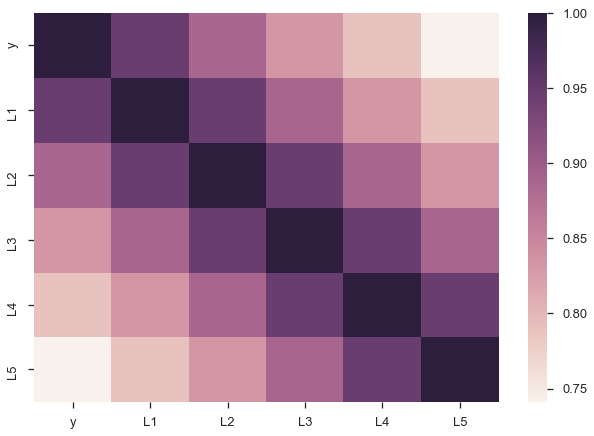

In [30]:
sns.heatmap(X.corr());

Second, we'd intuitively expect the $\beta_i$s to gradually decline to zero.
The immediately preceding period *should* be most important ($\beta_1$ is the largest coefficient in absolute value), followed by $\beta_2$, and $\beta_3$...
Looking at the regression summary and the bar graph below, this isn't the case (the cause is related to multicollinearity).

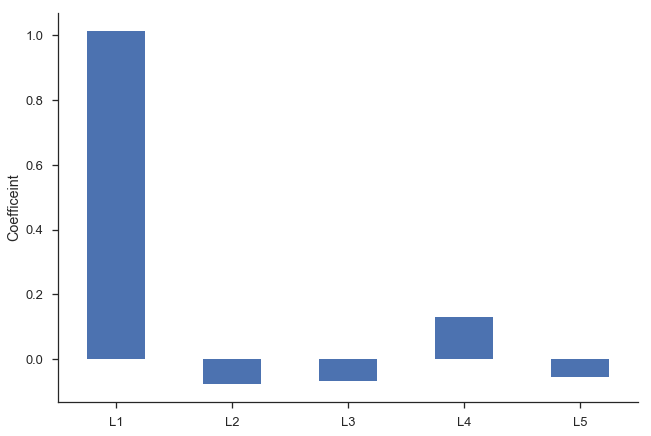

In [31]:
ax = res_lagged.params.drop(['Intercept', 'trend']).plot.bar(rot=0)
plt.ylabel('Coefficeint')
sns.despine()

Finally, our degrees of freedom drop since we lose two for each variable (one for estimating the coefficient, one for the lost observation as a result of the `shift`).
At least in (macro)econometrics, each observation is precious and we're loath to throw them away, though sometimes that's unavoidable.

### Autocorrelation

Another problem our lagged model suffered from is [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) (also know as serial correlation).
Roughly speaking, autocorrelation is when there's a clear pattern in the residuals of your regression (the observed minus the predicted).
Let's fit a simple model of $y = \beta_0 + \beta_1 T + \epsilon$, where `T` is the time trend (`np.arange(len(y))`).

In [32]:
# `Results.resid` is a Series of residuals: y - ŷ
mod_trend = sm.OLS.from_formula(
    'y ~ trend', data=y.to_frame(name='y')
                       .assign(trend=np.arange(len(y))))
res_trend = mod_trend.fit()

Residuals (the observed minus the expected, or $\hat{e_t} = y_t - \hat{y_t}$) are supposed to be [white noise](https://en.wikipedia.org/wiki/White_noise).
That's [one of the assumptions](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) many of the properties of linear regression are founded upon.
In this case there's a correlation between one residual and the next: if the residual at time $t$ was above expectation, then the residual at time $t + 1$ is *much* more likely to be above average as well ($e_t > 0 \implies E_t[e_{t+1}] > 0$).

We'll define a helper function to plot the residuals time series, and some diagnostics about them.

In [33]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

Calling it on the residuals from the linear trend:

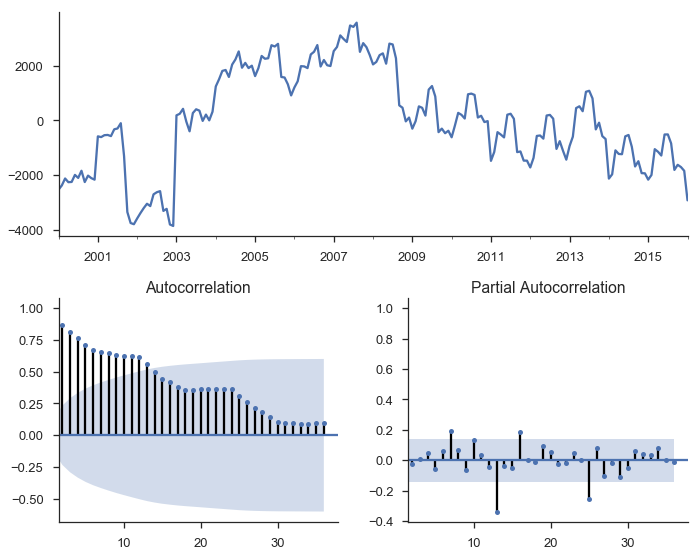

In [34]:
tsplot(res_trend.resid, lags=36);

The top subplot shows the time series of our residuals $e_t$, which should be white noise (but it isn't).
The bottom shows the [autocorrelation](https://www.otexts.org/fpp/2/2#autocorrelation) of the residuals as a correlogram.
It measures the correlation between a value and it's lagged self, e.g. $corr(e_t, e_{t-1}), corr(e_t, e_{t-2}), \ldots$.
The partial autocorrelation plot in the bottom-right shows a similar concept.
It's partial in the sense that the value for $corr(e_t, e_{t-k})$ is the correlation between those two periods, after controlling for the values at all shorter lags.

Autocorrelation is a problem in regular regressions like above, but we'll use it to our advantage when we setup an ARIMA model below.
The basic idea is pretty sensible: if your regression residuals have a clear pattern, then there's clearly some structure in the data that you aren't taking advantage of.
If a positive residual today means you'll likely have a positive residual tomorrow, why not incorporate that information into your forecast, and lower your forecasted value for tomorrow?
That's pretty much what ARIMA does.

It's important that your dataset be stationary, otherwise you run the risk of finding [spurious correlations](http://www.tylervigen.com/spurious-correlations).
A common example is the relationship between number of TVs per person and life expectancy.
It's not likely that there's an actual causal relationship there.
Rather, there could be a third variable that's driving both (wealth, say).
[Granger and Newbold (1974)](http://wolfweb.unr.edu/homepage/zal/STAT758/Granger_Newbold_1974.pdf) had some stern words for the econometrics literature on this.

> We find it very curious that whereas virtually every textbook on econometric methodology contains explicit warnings of the dangers of autocorrelated errors, this phenomenon crops up so frequently in well-respected applied work.

(:fire:), but in that academic passive-aggressive way.

The typical way to handle non-stationarity is to difference the non-stationary variable until is is stationary.

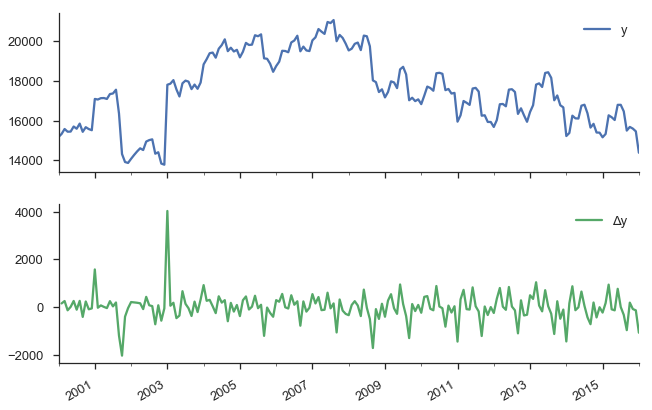

In [35]:
y.to_frame(name='y').assign(Δy=lambda x: x.y.diff()).plot(subplots=True)
sns.despine()

Our original series actually doesn't look *that* bad.
It doesn't look like nominal GDP say, where there's a clearly rising trend.
But we have more rigorous methods for detecting whether a series is non-stationary than simply plotting and squinting at it.
One popular method is the Augmented Dickey-Fuller test.
It's a statistical hypothesis test that roughly says:

$H_0$ (null hypothesis): $y$ is non-stationary, needs to be differenced

$H_A$ (alternative hypothesis): $y$ is stationary, doesn't need to be differenced

I don't want to get into the weeds on exactly what the test statistic is, and what the distribution looks like.
This is implemented in statsmodels as [`smt.adfuller`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).
The return type is a bit busy for me, so we'll wrap it in a `namedtuple`.

In [36]:
from collections import namedtuple

ADF = namedtuple("ADF", "adf pvalue usedlag nobs critical icbest")

In [37]:
ADF(*smt.adfuller(y))._asdict()

OrderedDict([('adf', -1.3206520699512339),
             ('pvalue', 0.61967180643147923),
             ('usedlag', 15),
             ('nobs', 177),
             ('critical',
              {'1%': -3.4678453197999071,
               '10%': -2.575551186759871,
               '5%': -2.8780117454974392}),
             ('icbest', 2710.6120408261486)])

So we failed to reject the null hypothesis that the original series was non-stationary.
Let's difference it.

In [38]:
ADF(*smt.adfuller(y.diff().dropna()))._asdict()

OrderedDict([('adf', -3.6412428797327996),
             ('pvalue', 0.0050197770854934548),
             ('usedlag', 14),
             ('nobs', 177),
             ('critical',
              {'1%': -3.4678453197999071,
               '10%': -2.575551186759871,
               '5%': -2.8780117454974392}),
             ('icbest', 2696.3891181091631)])

This looks better.
It's not statistically significant at the 5% level, but who cares what statisticins say anyway.

We'll fit another OLS model of $\Delta y = \beta_0 + \beta_1 L \Delta y_{t-1} + e_t$

In [39]:
data = (y.to_frame(name='y')
         .assign(Δy=lambda df: df.y.diff())
         .assign(LΔy=lambda df: df.Δy.shift()))
mod_stationary = smf.ols('Δy ~ LΔy', data=data.dropna())
res_stationary = mod_stationary.fit()

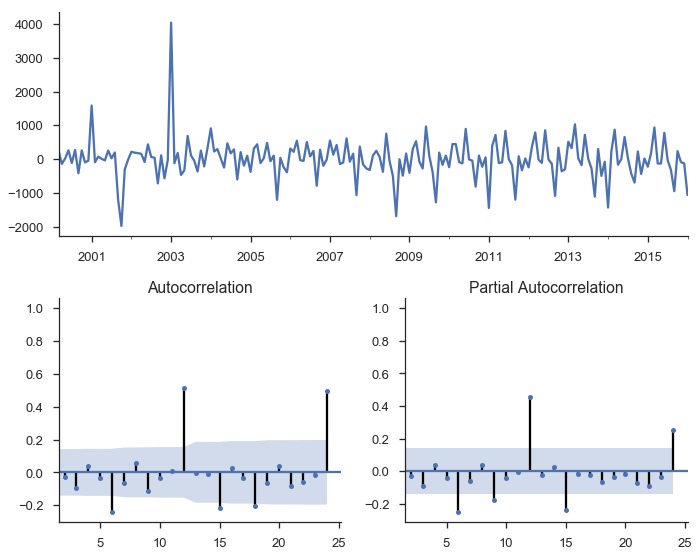

In [40]:
tsplot(res_stationary.resid, lags=24);

So we've taken care of multicolinearity, autocorelation, and stationarity, but we still aren't done.

## Seasonality

We have strong monthly seasonality:

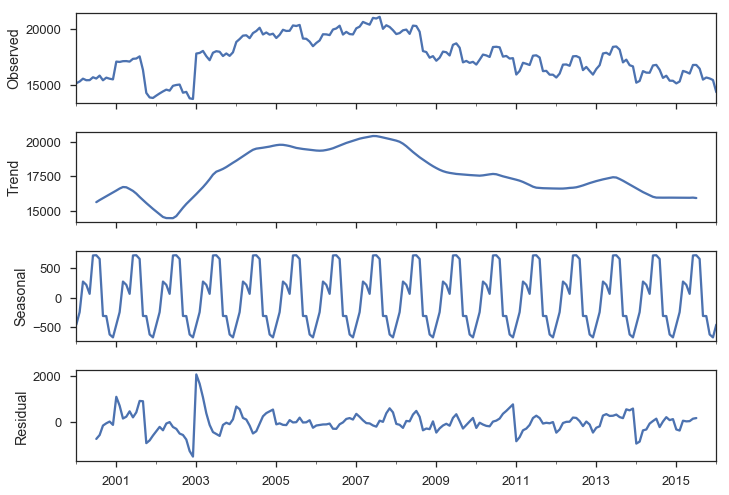

In [41]:
smt.seasonal_decompose(y).plot();

There are a few ways to handle seasonality.
We'll just rely on the `SARIMAX` method to do it for us.
For now, recognize that it's a problem to be solved.

## ARIMA

So, we've sketched the problems with regular old regression: multicollinearity, autocorrelation, non-stationarity, and seasonality.
Our tool of choice, `smt.SARIMAX`, which stands for Seasonal ARIMA with eXogenous regressors, can handle all these.
We'll walk through the components in pieces.

ARIMA stands for AutoRegressive Integrated Moving Average.
It's a relatively simple yet flexible way of modeling univariate time series.
It's made up of three components, and is typically written as $\mathrm{ARIMA}(p, d, q)$.

ARIMA stands for AutoRegressive Integrated Moving Average, and it's a relatively simple way of modeling univariate time series.
It's made up of three components, and is typically written as $\mathrm{ARIMA}(p, d, q)$.

### [AutoRegressive](https://www.otexts.org/fpp/8/3)

The idea is to predict a variable by a linear combination of its lagged values (*auto*-regressive as in regressing a value on its past *self*).
An AR(p), where $p$ represents the number of lagged values used, is written as

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + e_t$$

$c$ is a constant and $e_t$ is white noise.
This looks a lot like a linear regression model with multiple predictors, but the predictors happen to be lagged values of $y$ (though they are estimated differently).

### Integrated

Integrated is like the opposite of differencing, and is the part that deals with stationarity.
If you have to difference your dataset 1 time to get it stationary, then $d=1$.
We'll introduce one bit of notation for differencing: $\Delta y_t = y_t - y_{t-1}$ for $d=1$.

### [Moving Average](https://www.otexts.org/fpp/8/4)

MA models look somewhat similar to the AR component, but it's dealing with different values.

$$y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \ldots + \theta_q e_{t-q}$$

$c$ again is a constant and $e_t$ again is white noise.
But now the coefficients are the *residuals* from previous predictions.

### Combining

Putting that together, an ARIMA(1, 1, 1) process is written as

$$\Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_t e_{t-1} + e_t$$

Using *lag notation*, where $L y_t = y_{t-1}$, i.e. `y.shift()` in pandas, we can rewrite that as

$$(1 - \phi_1 L) (1 - L)y_t = c + (1 + \theta L)e_t$$

That was for our specific $\mathrm{ARIMA}(1, 1, 1)$ model. For the general $\mathrm{ARIMA}(p, d, q)$, that becomes

$$(1 - \phi_1 L - \ldots - \phi_p L^p) (1 - L)^d y_t = c + (1 + \theta L + \ldots + \theta_q L^q)e_t$$

We went through that *extremely* quickly, so don't feel bad if things aren't clear.
Fortunately, the model is pretty easy to use with statsmodels (using it *correctly*, in a statistical sense, is another matter).

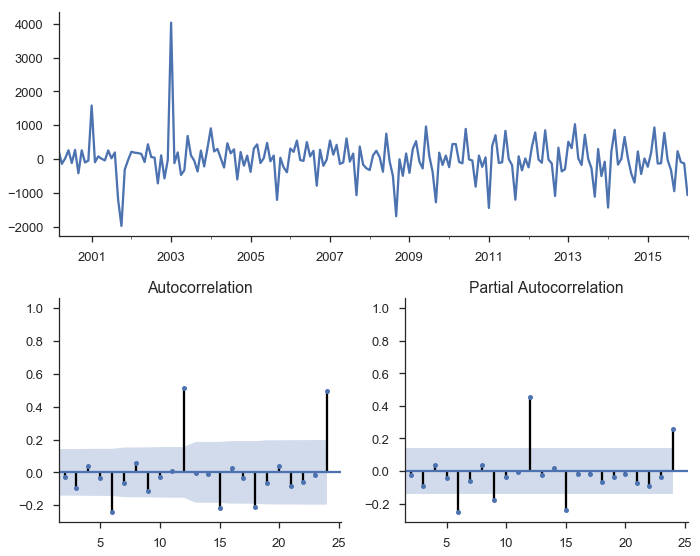

In [42]:
mod = smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res = mod.fit()
tsplot(res.resid[2:], lags=24);

In [43]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                fl_date   No. Observations:                  193
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1494.618
Date:                Sun, 03 Sep 2017   AIC                           2997.236
Time:                        11:12:22   BIC                           3010.287
Sample:                    01-01-2000   HQIC                          3002.521
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.4306     66.818     -0.081      0.935    -136.391     125.529
ar.L1         -0.0327      2.689     -0.012      0.990      -5.303       5.237
ma.L1          0.0775      2.667      0.029      0.977      -5.149       5.305
sigma2      3.444e+05   1.69e+04     20.392      0.000    3.11e+05    3.77e+05
===================================================================================
Ljung-Box (Q):                      225.58   Jarque-Bera (JB):              1211.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.20
Prob(H) (two-sided):                  0.12   Kurtosis:                        15.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There's a bunch of output there with various tests, estimated parameters, and information criteria.
Let's just say that things are looking better, but we still haven't accounted for seasonality.

A seasonal ARIMA model is written as $\mathrm{ARIMA}(p,d,q)×(P,D,Q)_s$.
Lowercase letters are for the non-seasonal component, just like before. Upper-case letters are a similar specification for the seasonal component, where $s$ is the periodicity (4 for quarterly, 12 for monthly).

It's like we have two processes, one for non-seasonal component and one for seasonal components, and we multiply them together with regular algebra rules.

The general form of that looks like (quoting the [statsmodels docs](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) here)

$$\phi_p(L)\tilde{\phi}_P(L^S)\Delta^d\Delta_s^D y_t = A(t) + \theta_q(L)\tilde{\theta}_Q(L^s)e_t$$

where

- $\phi_p(L)$ is the non-seasonal autoregressive lag polynomial
- $\tilde{\phi}_P(L^S)$ is the seasonal autoregressive lag polynomial
- $\Delta^d\Delta_s^D$ is the time series, differenced  $d$ times, and seasonally differenced $D$ times.
- $A(t)$ is the trend polynomial (including the intercept)
- $\theta_q(L)$ is the non-seasonal moving average lag polynomial
- $\tilde{\theta}_Q(L^s)$  is the seasonal moving average lag polynomial

I don't find that to be very clear, but maybe an example will help.
We'll fit a seasonal ARIMA$(1,1,2)×(0, 1, 2)_{12}$.

So the nonseasonal component is

- $p=1$: period autoregressive: use $y_{t-1}$
- $d=1$: one first-differencing of the data (one month)
- $q=2$: use the previous two non-seasonal residual, $e_{t-1}$ and $e_{t-2}$, to forecast

And the seasonal component is

- $P=0$: Don't use any previous seasonal values
- $D=1$: Difference the series 12 periods back: `y.diff(12)`
- $Q=2$: Use the two previous seasonal residuals

In [44]:
mod_seasonal = smt.SARIMAX(y, trend='c',
                           order=(1, 1, 2), seasonal_order=(0, 1, 2, 12),
                           simple_differencing=False)
res_seasonal = mod_seasonal.fit()

In [45]:
res_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            fl_date   No. Observations:                  193
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -1357.847
Date:                            Sun, 03 Sep 2017   AIC                           2729.694
Time:                                    11:12:25   BIC                           2752.533
Sample:                                01-01-2000   HQIC                          2738.943
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -17.5871     44.920     -0.392      0.695    -105.628      70.454
ar.L1         -0.9988      0.013    -74.479      0.000      -1.025      -0.973
ma.L1          0.9956      0.109      9.130      0.000       0.782       1.209
ma.L2          0.0042      0.110      0.038      0.969      -0.211       0.219
ma.S.L12      -0.7836      0.059    -13.286      0.000      -0.899      -0.668
ma.S.L24       0.2118      0.041      5.154      0.000       0.131       0.292
sigma2      1.842e+05   1.21e+04     15.240      0.000    1.61e+05    2.08e+05
===================================================================================
Ljung-Box (Q):                       32.57   Jarque-Bera (JB):              1298.39
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

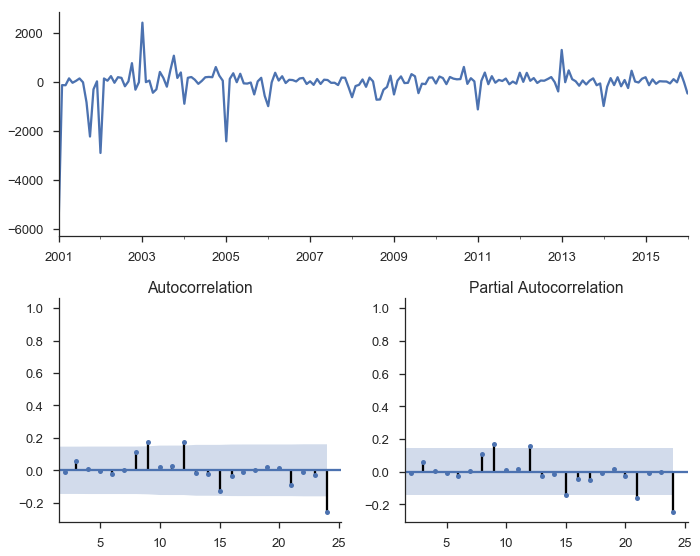

In [46]:
tsplot(res_seasonal.resid[12:], lags=24);

Things look much better now.

One thing I didn't really talk about is order selection. How to choose $p, d, q, P, D$ and $Q$.
R's forecast package does have a handy `auto.arima` function that does this for you.
Python / statsmodels don't have that at the minute.
The alternative seems to be experience (boo), intuition (boo), and good-old grid-search.
You can fit a bunch of models for a bunch of combinations of the parameters and use the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) to choose the best.
[Here](https://www.otexts.org/fpp/8/7) is a useful reference, and [this](http://stackoverflow.com/a/22770973) StackOverflow answer recommends a few options.


## Forecasting

Now that we fit that model, let's put it to use.
First, we'll make a bunch of one-step ahead forecasts.
At each point (month), we take the history up to that point and make a forecast for the next month.
So the forecast for January 2014 has available all the data up through December 2013.

In [47]:
pred = res_seasonal.get_prediction(start='2001-03-01')
pred_ci = pred.conf_int()

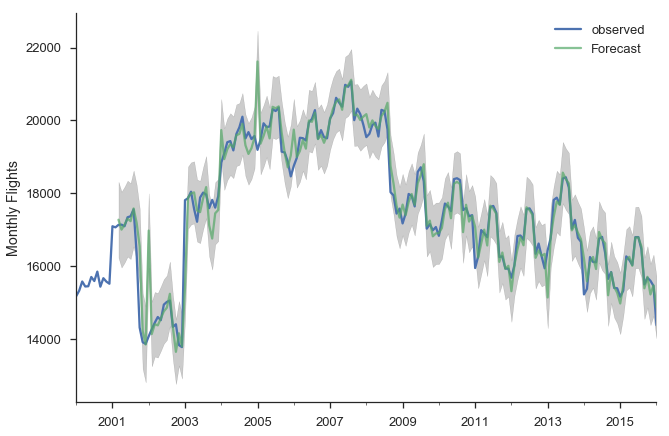

In [49]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel("Monthly Flights")
plt.legend()
sns.despine()

There are a few places where the observed series slips outside the 95% confidence interval.
The series seems especially unstable before 2005.

Alternatively, we can make *dynamic* forecasts as of some month (January 2013 in the example below).
That means the forecast from that point forward only use information available as of January 2013.
The predictions are generated in a similar way: a bunch of one-step forecasts.
Only instead of plugging in the *actual* values beyond January 2013, we plug in the *forecast* values.

In [50]:
pred_dy = res_seasonal.get_prediction(start='2002-03-01', dynamic='2013-01-01')
pred_dy_ci = pred_dy.conf_int()

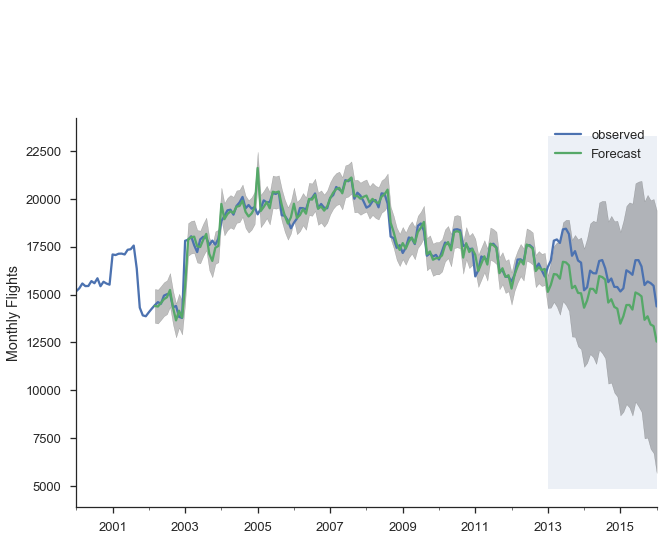

In [51]:
ax = y.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel("Monthly Flights")

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2013-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2013-02-01'), 550))

plt.legend()
sns.despine()

## Resources

This is a collection of links for those interested.

### Time series modeling in Python

+ [Statsmodels Statespace Notebooks](http://www.statsmodels.org/dev/examples/index.html#statespace)
+ [Statsmodels VAR tutorial](http://www.statsmodels.org/dev/vector_ar.html#var)
- [ARCH Library by Kevin Sheppard](https://github.com/bashtage/arch)

### General Textbooks

- [Forecasting: Principles and Practice](https://www.otexts.org/fpp/): A great introduction
- [Stock and Watson](http://wps.aw.com/aw_stock_ie_3/178/45691/11696965.cw/): Readable undergraduate resource, has a few chapters on time series
- [Greene's Econometric Analysis](http://pages.stern.nyu.edu/~wgreene/Text/econometricanalysis.htm): My favorite PhD level textbook
- [Hamilton's Time Series Analysis](http://www.amazon.com/Time-Analysis-James-Douglas-Hamilton/dp/0691042896): A classic
- [Lutkehpohl's New Introduction to Multiple Time Series Analysis](http://www.amazon.com/New-Introduction-Multiple-Time-Analysis/dp/3540262393): Extremely dry, but useful if you're implementing this stuff

## Conclusion

Congratulations if you made it this far, this piece just kept growing (and I still had to cut stuff).
The main thing cut was talking about how `SARIMAX` is implemented on top of using statsmodels' statespace framework.
The statespace framework, developed mostly by Chad Fulton over the past couple years, is really nice.
You can pretty easily [extend it](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html) with custom models, but still get all the benefits of the framework's estimation and results facilities.
I'd recommend reading the [notebooks](http://www.statsmodels.org/dev/examples/index.html#statespace).
We also didn't get to talk at all about Skipper Seabold's work on VARs, but maybe some other time.

As always, [feedback is welcome](https://twitter.com/tomaugspurger).